In [178]:
import pandas as pd 
from collections import Counter
from imblearn.over_sampling import SMOTE

# For Train
x_train_fe = pd.read_csv("x_train_fe_1.csv")
y_train = x_train_fe['PotentialFraud']

# For Test
x_val_fe = pd.read_csv("x_val_fe_1.csv")
y_val = x_val_fe['PotentialFraud']

# For Advanced Model 
graph_df = pd.read_csv("provider_graph_features.csv")
embed_train = pd.read_pickle('data/embed_df_train.pkl').reset_index().rename({'index': 'Provider'}, axis=1)
embed_val = pd.read_pickle('data/embed_df_val.pkl').reset_index().rename({'index': 'Provider'}, axis=1)

In [179]:
# Merging graph dfs 
graph = graph_df.drop(['PotentialFraud'], axis=1)

x_train_joined = pd.merge(x_train_fe, graph, on='Provider', how='left')
x_val_fe_joined = pd.merge(x_val_fe, graph, on='Provider', how='left')

# Merging embedding dfs 
x_train_joined = pd.merge(x_train_joined, embed_train, on='Provider', how='left')
x_val_fe_joined = pd.merge(x_val_fe_joined, embed_val, on='Provider', how='left')

# Drop target columns & impute NaNs with 0
x_train_full = x_train_joined.drop(['PotentialFraud', 'Provider'], axis=1)
x_val_full = x_val_fe_joined.drop(['PotentialFraud', 'Provider'], axis=1)

x_train_full.fillna(0, inplace=True)
x_val_full.fillna(0, inplace=True)

In [180]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Convert all cols to float64 to fit into tensor
X_train_float = x_train_full.astype('float64')

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
x_train_sm_full, y_train_sm = smt.fit_resample(X_train_float, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({False: 3927, True: 401})


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


After Counter({False: 3927, True: 3927})


#### Helper Function

In [181]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import pandas as pd

def evaluate_model_performance(model, x_train_sm, y_train_sm, x_val, y_val):
    # Predictions
    y_train_pred = model.predict(x_train_sm)
    y_val_pred = model.predict(x_val)

    # Calculate metrics for training
    precision_train = precision_score(y_train_sm, y_train_pred)
    recall_train = recall_score(y_train_sm, y_train_pred)
    accuracy_train = accuracy_score(y_train_sm, y_train_pred)
    f1_score_train = f1_score(y_train_sm, y_train_pred)

    # Calculate metrics for validation
    precision_val = precision_score(y_val, y_val_pred)
    recall_val = recall_score(y_val, y_val_pred)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    f1_score_val = f1_score(y_val, y_val_pred)

    # Organize the metrics into a DataFrame
    metrics_data = {
        'Precision': [precision_train, precision_val],
        'Recall': [recall_train, recall_val],
        'Accuracy': [accuracy_train, accuracy_val],
        'F1 score': [f1_score_train, f1_score_val]
    }
    index_labels = ['Training set eval', 'Validation set eval']
    df_metrics = pd.DataFrame(data=metrics_data, index=index_labels)
    return df_metrics


### 1. Baseline Model
- Drop graph related columns

In [183]:
adv_model_col = list(graph_df.columns[2:]) + list(embed_train.columns[1:])

x_train_sm = x_train_sm_full.drop(adv_model_col, axis=1)
x_val = x_val_full.drop(adv_model_col, axis=1)

#### 1.1 Logistic Regression 
- Fit with everything

In [140]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

log_sm = LogisticRegressionCV(
    cv=10, 
    class_weight='balanced', 
    random_state=123,
    max_iter=10000,
    solver='saga' 
)

log_sm.fit(x_train_sm, y_train_sm)

LogisticRegressionCV(class_weight='balanced', cv=10, max_iter=10000,
                     random_state=123, solver='saga')

In [142]:
evaluate_model_performance(log_sm, x_train_sm, y_train_sm, x_val, y_val)

,Precision,Recall,Accuracy,F1 score
Training set eval,0.887622,0.832697,0.863636,0.859283
Validation set eval,0.464481,0.809524,0.890943,0.590278


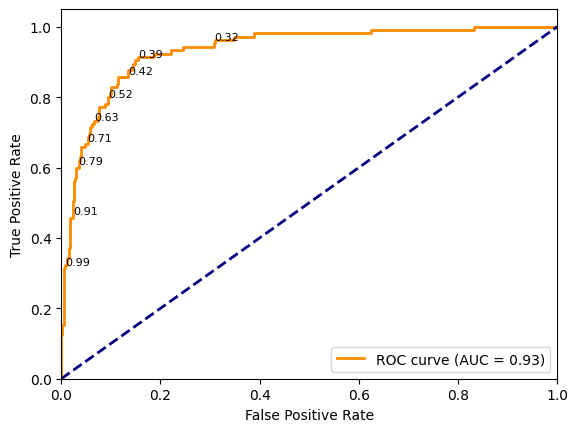

In [144]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_val_pred_probs = log_sm.predict_proba(x_val)[:, 1]

# Compute ROC curve and ROC area for the validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_probs)  # y_val_pred_probs already computed
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Label a few threshold values on the curve
for i in range(1, 10, 1):
    threshold_label_index = i * len(thresholds) // 10
    plt.text(fpr[threshold_label_index], tpr[threshold_label_index], f"{thresholds[threshold_label_index]:.2f}", fontdict={'size': 8})

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#### 1.2 KNN
- fit with everything

In [145]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN classifier
knn_all_features = KNeighborsClassifier(n_neighbors=5)

# Fit the KNN classifier to the training data
knn_all_features.fit(x_train_sm, y_train_sm)

evaluate_model_performance(knn_all_features, x_train_sm, y_train_sm, x_val, y_val)

KNeighborsClassifier()

- Feature importance for top 10

In [147]:
from sklearn.inspection import permutation_importance

# Perform permutation importance
results = permutation_importance(knn_all_features, x_val, y_val, scoring='accuracy')

# Get the importance scores
importance_scores = results.importances_mean

# Map the scores with the feature names and extract top 10
feature_importances = dict(zip(x_train_sm.columns, importance_scores))
top_10_features = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 feature importances:", top_10_features)

Top 10 feature importances: [('SUM(X.NoOfMonths_PartACov)', 0.031977818853974105), ('SUM(X.DeductibleAmtPaid)', 0.024768946395563773), ('NUM_UNIQUE(X.ClmAdmitDiagnosisCode_ce)', 0.018853974121996298), ('NUM_UNIQUE(X.DiagnosisGroupCode_ce)', 0.017744916820702405), ('SUM(X.Age)', 0.016081330868761533), ('SUM(X.NoOfMonths_PartBCov)', 0.01515711645101665), ('COUNT(X)', 0.01423290203327172), ('NUM_UNIQUE(X.ClmDiagnosisCode_4_ce)', 0.012014787430683937), ('NUM_UNIQUE(X.ClmDiagnosisCode_8_ce)', 0.011829944547134952), ('NUM_UNIQUE(X.ClmDiagnosisCode_9_ce)', 0.01146025878003698)]


- Fit with top 10

In [148]:

# Extract the top 10 feature names
top_10_feature_names = [feature[0] for feature in top_10_features]

# Select the top 10 features from the training and validation sets
x_train_top_10 = x_train_sm[top_10_feature_names]
x_val_top_10 = x_val[top_10_feature_names]

# Initialize the KNN classifier
knn_top_10 = KNeighborsClassifier(n_neighbors=5)

# Fit the KNN classifier to the training data with top 10 features
knn_top_10.fit(x_train_top_10, y_train_sm)

evaluate_model_performance(knn_top_10, x_train_top_10, y_train_sm, x_val_top_10, y_val)

KNeighborsClassifier()

- Fit with top 10 HPT (GridSearchCV to search for the best n_neighbors)

In [150]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_neighbors': range(1, 31)}

# Initialize the KNN classifier
knn_top_10_tuned = KNeighborsClassifier()

# Initialize the GridSearchCV object
grid_search = GridSearchCV(knn_top_10_tuned, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data with top 10 features
grid_search.fit(x_train_top_10, y_train_sm)

# Output the best parameters
print("Best parameters:", grid_search.best_params_)

evaluate_model_performance(grid_search.best_estimator_, x_train_top_10, y_train_sm, x_val_top_10, y_val)

Best parameters: {'n_neighbors': 1}


### 2. Advanced Model

In [189]:
# x_train
x_train_sm_full # for all
x_train_sm_graph = x_train_sm_full.drop(list(embed_train.columns[1:]), axis = 1)
x_train_sm_embed = x_train_sm_full.drop(list(graph_df.columns[2:]), axis = 1)

# x_val
x_val_full # for all
x_val_graph = x_val_full.drop(list(embed_train.columns[1:]), axis = 1)
x_val_embed = x_val_full.drop(list(graph_df.columns[2:]), axis = 1)

,COUNT(X),MAX(X.AdmitForDays),MAX(X.Age),MAX(X.ClaimProcessedForDays),MAX(X.DeductibleAmtPaid),MAX(X.IPAnnualDeductibleAmt),MAX(X.IPAnnualReimbursementAmt),MAX(X.InscClaimAmtReimbursed),MAX(X.NoOfMonths_PartACov),MAX(X.NoOfMonths_PartBCov),...,758,759,760,761,762,763,764,765,766,767
0,107,0.777778,1.000000,0.750000,1.0,0.188232,0.475010,0.41600,1.0,1.0,...,-0.420393,-0.422371,-0.196416,0.218691,0.085898,-0.058792,-0.296972,-0.564798,-0.180807,0.104117
1,26,0.583333,0.920000,0.555556,1.0,0.083717,0.424854,0.21600,1.0,1.0,...,-0.407410,-0.614789,-0.702504,0.538996,0.331245,-0.391218,-0.531039,-0.416015,-0.105309,0.015756
2,618,0.750000,1.000000,0.722222,1.0,0.811768,0.832537,0.68000,1.0,1.0,...,-0.567851,-0.557425,-0.328434,0.214911,-0.000003,-0.362081,-0.432876,-0.956554,0.085556,0.456871
3,44,1.000000,0.906667,0.972222,1.0,0.864026,0.821030,0.81600,1.0,1.0,...,-0.255119,-0.486029,-0.471843,0.176991,0.106399,-0.502323,-0.436836,-0.562053,0.260381,0.294990
4,66,0.555556,0.973333,0.527778,1.0,0.139528,0.551130,0.48800,1.0,1.0,...,-0.300766,-0.655239,-0.631386,-0.031047,-0.078908,-0.339972,-0.289837,-0.626141,-0.104106,-0.199145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,1,0.000000,0.800000,0.000000,0.0,0.000000,0.047206,0.00008,1.0,1.0,...,-0.030288,0.162271,0.160413,0.165034,-0.005263,-0.008865,0.186576,-0.644718,0.109574,0.024836
1078,1,0.000000,0.813333,0.000000,0.0,0.027906,0.082610,0.00048,1.0,1.0,...,0.095540,-0.128392,-0.149609,0.514402,0.242470,-0.474100,0.125255,-0.316913,-0.144534,0.319476
1079,1,0.000000,0.840000,0.000000,0.0,0.000000,0.047206,0.00160,1.0,1.0,...,-0.098113,-0.554054,-0.123831,-0.606267,0.139732,0.149492,-0.268450,-0.669689,0.009811,0.067680
1080,1,0.000000,0.560000,0.000000,0.0,0.000000,0.047206,0.00240,1.0,1.0,...,-0.391746,-0.036987,-0.279863,-0.404229,-0.049027,-0.637334,-0.369818,-0.511247,0.279507,0.335351


#### 2.1 Graph only

##### 2.1.1 Logistic Regression

In [190]:
log_graph = LogisticRegressionCV(
    cv=10, 
    class_weight='balanced', 
    random_state=123,
    max_iter=10000,
    solver='saga' 
)

log_graph.fit(x_train_sm_graph, y_train_sm)

LogisticRegressionCV(class_weight='balanced', cv=10, max_iter=10000,
                     random_state=123, solver='saga')

In [191]:
evaluate_model_performance(log_graph, x_train_sm_graph, y_train_sm, x_val_graph, y_val)

,Precision,Recall,Accuracy,F1 score
Training set eval,0.871337,0.832951,0.854978,0.851712
Validation set eval,0.429293,0.809524,0.877079,0.561056


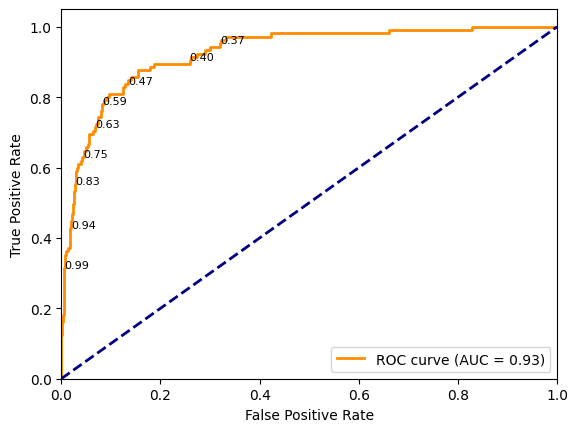

In [192]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_val_pred_probs = log_graph.predict_proba(x_val_graph)[:, 1]

# Compute ROC curve and ROC area for the validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_probs)  # y_val_pred_probs already computed
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Label a few threshold values on the curve
for i in range(1, 10, 1):
    threshold_label_index = i * len(thresholds) // 10
    plt.text(fpr[threshold_label_index], tpr[threshold_label_index], f"{thresholds[threshold_label_index]:.2f}", fontdict={'size': 8})

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

##### 2.1.2 KNN
- fit with everything

In [193]:
from sklearn.neighbors import KNeighborsClassifier

knn_all_features = KNeighborsClassifier(n_neighbors=5)
knn_all_features.fit(x_train_sm_graph, y_train_sm)

evaluate_model_performance(knn_all_features, x_train_sm_graph, y_train_sm, x_val_graph, y_val)

,Precision,Recall,Accuracy,F1 score
Training set eval,0.881230,0.999491,0.932391,0.936642
Validation set eval,0.352423,0.761905,0.841035,0.481928


- Find feature importance for top 10

In [194]:
from sklearn.inspection import permutation_importance

# Perform permutation importance
results = permutation_importance(knn_all_features, x_val_graph, y_val, scoring='accuracy')

# Map the scores with the feature names and extract top 10
importance_scores = results.importances_mean
feature_importances = dict(zip(x_train_sm_graph.columns, importance_scores))
top_10_features = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 feature importances:", top_10_features)

Top 10 feature importances: [('NUM_UNIQUE(X.ClmDiagnosisCode_4_ce)', 0.015896487985212572), ('SUM(X.DeductibleAmtPaid)', 0.012014787430683915), ('NUM_UNIQUE(X.ClmDiagnosisCode_5_ce)', 0.008317929759704223), ('NUM_UNIQUE(X.ClmDiagnosisCode_7_ce)', 0.005175600739371511), ('NUM_UNIQUE(X.ClmProcedureCode_1_ce)', 0.004990757855822525), ('SKEW(X.InscClaimAmtReimbursed)', 0.004805914972273539), ('NUM_UNIQUE(X.ClmDiagnosisCode_9_ce)', 0.004621072088724576), ('NUM_UNIQUE(X.ClmProcedureCode_2_ce)', 0.004251386321626582), ('SKEW(X.OPAnnualDeductibleAmt)', 0.003881700554528633), ('SUM(X.AdmitForDays)', 0.0031423290203327126)]


- Fit top 10 features

In [195]:
# Extract the top 10 feature names
top_10_feature_names = [feature[0] for feature in top_10_features]
x_train_top_10 = x_train_sm_graph[top_10_feature_names]
x_val_top_10 = x_val_graph[top_10_feature_names]

# Fit the KNN classifier to the training data with top 10 features
knn_top_10 = KNeighborsClassifier(n_neighbors=5)
knn_top_10.fit(x_train_top_10, y_train_sm)

evaluate_model_performance(knn_top_10, x_train_top_10, y_train_sm, x_val_top_10, y_val)

,Precision,Recall,Accuracy,F1 score
Training set eval,0.891948,0.990069,0.935065,0.938450
Validation set eval,0.364035,0.790476,0.845656,0.498498


- Fit with top 10 HPT (GridSearchCV to search for the best n_neighbors)

In [196]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 31)}
knn_top_10_tuned = KNeighborsClassifier()
grid_search = GridSearchCV(knn_top_10_tuned, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data with top 10 features
grid_search.fit(x_train_top_10, y_train_sm)
print("Best parameters:", grid_search.best_params_)

evaluate_model_performance(grid_search.best_estimator_, x_train_top_10, y_train_sm, x_val_top_10, y_val)

Best parameters: {'n_neighbors': 2}


,Precision,Recall,Accuracy,F1 score
Training set eval,1.000000,0.986504,0.993252,0.993206
Validation set eval,0.415584,0.609524,0.878928,0.494208


#### 2.2 Embedding only

##### 2.2.1 Logistic Regression

In [197]:
log_embed = LogisticRegressionCV(
    cv=10, 
    class_weight='balanced', 
    random_state=123,
    max_iter=10000,
    solver='saga' 
)

log_embed.fit(x_train_sm_embed, y_train_sm)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LogisticRegressionCV(class_weight='balanced', cv=10, max_iter=10000,
                     random_state=123, solver='saga')

In [198]:
evaluate_model_performance(log_embed, x_train_sm_embed, y_train_sm, x_val_embed, y_val)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,Precision,Recall,Accuracy,F1 score
Training set eval,0.895592,0.827858,0.865674,0.860394
Validation set eval,0.482558,0.790476,0.897412,0.599278


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


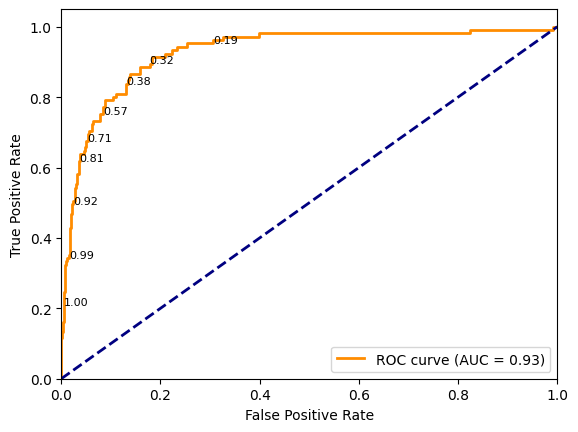

In [199]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_val_pred_probs = log_embed.predict_proba(x_val_embed)[:, 1]

# Compute ROC curve and ROC area for the validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_probs)  # y_val_pred_probs already computed
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Label a few threshold values on the curve
for i in range(1, 10, 1):
    threshold_label_index = i * len(thresholds) // 10
    plt.text(fpr[threshold_label_index], tpr[threshold_label_index], f"{thresholds[threshold_label_index]:.2f}", fontdict={'size': 8})

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

##### 2.2.2 KNN
- fit with everything

In [200]:
from sklearn.neighbors import KNeighborsClassifier

knn_all_features = KNeighborsClassifier(n_neighbors=5)
knn_all_features.fit(x_train_sm_embed, y_train_sm)

evaluate_model_performance(knn_all_features, x_train_sm_embed, y_train_sm, x_val_embed, y_val)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,Precision,Recall,Accuracy,F1 score
Training set eval,0.863836,1.000000,0.921187,0.926944
Validation set eval,0.356000,0.847619,0.836414,0.501408


- Find feature importance for top 10

In [201]:
from sklearn.inspection import permutation_importance

# Perform permutation importance
results = permutation_importance(knn_all_features, x_val_embed, y_val, scoring='accuracy')

# Map the scores with the feature names and extract top 10
importance_scores = results.importances_mean
feature_importances = dict(zip(x_train_sm_embed.columns, importance_scores))
top_10_features = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 feature importances:", top_10_features)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that a

Top 10 feature importances: [('SUM(X.DeductibleAmtPaid)', 0.021996303142329032), ('SUM(X.NoOfMonths_PartACov)', 0.021811460258780068), ('NUM_UNIQUE(X.DiagnosisGroupCode_ce)', 0.01719038817005549), ('SUM(X.Age)', 0.014417744916820708), ('NUM_UNIQUE(X.ClmDiagnosisCode_4_ce)', 0.014048059149722781), ('NUM_UNIQUE(X.ClmDiagnosisCode_8_ce)', 0.012754158964879924), ('NUM_UNIQUE(X.ClmDiagnosisCode_7_ce)', 0.01146025878003698), ('NUM_UNIQUE(X.ClmDiagnosisCode_5_ce)', 0.011090573012939031), ('COUNT(X)', 0.010166358595194148), ('NUM_UNIQUE(X.County)', 0.00905730129390021)]


- Fit top 10 features

In [202]:
# Extract the top 10 feature names
top_10_feature_names = [feature[0] for feature in top_10_features]
x_train_top_10 = x_train_sm_embed[top_10_feature_names]
x_val_top_10 = x_val_embed[top_10_feature_names]

# Initialize the KNN classifier
knn_top_10 = KNeighborsClassifier(n_neighbors=5)

# Fit the KNN classifier to the training data with top 10 features
knn_top_10.fit(x_train_top_10, y_train_sm)

evaluate_model_performance(knn_top_10, x_train_top_10, y_train_sm, x_val_top_10, y_val)

,Precision,Recall,Accuracy,F1 score
Training set eval,0.896480,0.992361,0.938885,0.941987
Validation set eval,0.382075,0.771429,0.856747,0.511041


- Fit with top 10 HPT (GridSearchCV to search for the best n_neighbors)

In [203]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 31)}
knn_top_10_tuned = KNeighborsClassifier()
grid_search = GridSearchCV(knn_top_10_tuned, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data with top 10 features
grid_search.fit(x_train_top_10, y_train_sm)
print("Best parameters:", grid_search.best_params_)

evaluate_model_performance(grid_search.best_estimator_, x_train_top_10, y_train_sm, x_val_top_10, y_val)

Best parameters: {'n_neighbors': 2}


,Precision,Recall,Accuracy,F1 score
Training set eval,1.000000,0.988286,0.994143,0.994109
Validation set eval,0.424658,0.590476,0.882625,0.494024


#### 2.3 Graph and Embeddings

##### 2.3.1 Logistic Regression

In [204]:
log_full = LogisticRegressionCV(
    cv=10, 
    class_weight='balanced', 
    random_state=123,
    max_iter=10000,
    solver='saga' 
)

log_full.fit(x_train_sm_full, y_train_sm)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LogisticRegressionCV(class_weight='balanced', cv=10, max_iter=10000,
                     random_state=123, solver='saga')

In [205]:
evaluate_model_performance(log_full, x_train_sm_full, y_train_sm, x_val_full, y_val)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,Precision,Recall,Accuracy,F1 score
Training set eval,0.891322,0.818691,0.859435,0.853464
Validation set eval,0.488095,0.780952,0.899261,0.600733


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


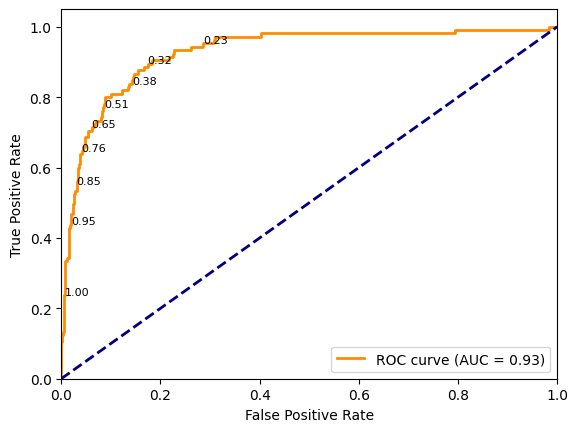

In [206]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_val_pred_probs = log_full.predict_proba(x_val_full)[:, 1]

# Compute ROC curve and ROC area for the validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_probs)  # y_val_pred_probs already computed
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Label a few threshold values on the curve
for i in range(1, 10, 1):
    threshold_label_index = i * len(thresholds) // 10
    plt.text(fpr[threshold_label_index], tpr[threshold_label_index], f"{thresholds[threshold_label_index]:.2f}", fontdict={'size': 8})

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

##### 2.3.2 KNN
- fit with everything

In [207]:
from sklearn.neighbors import KNeighborsClassifier

knn_all_features = KNeighborsClassifier(n_neighbors=5)
knn_all_features.fit(x_train_sm_full, y_train_sm)

evaluate_model_performance(knn_all_features, x_train_sm_full, y_train_sm, x_val_full, y_val)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,Precision,Recall,Accuracy,F1 score
Training set eval,0.866064,0.999491,0.922460,0.928006
Validation set eval,0.340336,0.771429,0.832717,0.472303


- Find feature importance for top 10

In [208]:
from sklearn.inspection import permutation_importance

# Perform permutation importance
results = permutation_importance(knn_all_features, x_val_full, y_val, scoring='accuracy')

# Map the scores with the feature names and extract top 10
importance_scores = results.importances_mean
feature_importances = dict(zip(x_train_sm_full.columns, importance_scores))
top_10_features = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 feature importances:", top_10_features)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that a

KeyboardInterrupt: 

- Fit top 10 features

In [ ]:
# Extract the top 10 feature names
top_10_feature_names = [feature[0] for feature in top_10_features]
x_train_top_10 = x_train_sm_full[top_10_feature_names]
x_val_top_10 = x_val_full[top_10_feature_names]

# Initialize the KNN classifier
knn_top_10 = KNeighborsClassifier(n_neighbors=5)

# Fit the KNN classifier to the training data with top 10 features
knn_top_10.fit(x_train_top_10, y_train_sm)

evaluate_model_performance(knn_top_10, x_train_top_10, y_train_sm, x_val_top_10, y_val)

,Precision,Recall,Accuracy,F1 score
Training set eval,0.891364,0.988286,0.933919,0.937326
Validation set eval,0.364807,0.809524,0.844732,0.502959


- Fit with top 10 HPT (GridSearchCV to search for the best n_neighbors)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 31)}
knn_top_10_tuned = KNeighborsClassifier()
grid_search = GridSearchCV(knn_top_10_tuned, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data with top 10 features
grid_search.fit(x_train_top_10, y_train_sm)
print("Best parameters:", grid_search.best_params_)

evaluate_model_performance(grid_search.best_estimator_, x_train_top_10, y_train_sm, x_val_top_10, y_val)

Best parameters: {'n_neighbors': 2}


,Precision,Recall,Accuracy,F1 score
Training set eval,1.000000,0.981920,0.990960,0.990878
Validation set eval,0.405063,0.609524,0.875231,0.486692
